In [22]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pickle

class InvertedPendulum:
    def __init__(self, m, l, g, k) -> None:
        self.m, self.l, self.g, self.k = m, l, g, k

    def thetaDDot(self, Theta, Tau):
        return 1.5*self.g/self.l*np.sin(Theta) - Tau*3/self.m/self.l**2
    
    def DynSS(self, y, t,Tau):
        Theta, Omega = y
        dydt = [Omega, -1.5*self.g/self.l*np.sin(Theta) + 3*Tau/self.m/self.l**2 - 3*self.k*Omega/self.m/self.l**2]
        return dydt
    
    def nextState(self, y,Tau, Ts):
        y0 = y
        sol = odeint(self.DynSS, y0, [0, Ts], args=(Tau,))
        return sol[1,:]

def reward(Theta, ThetaTarget):
    return 1- np.cos(Theta)

def closestDiscInd(DiscArr, val):
    diff = np.absolute(DiscArr -val)
    Ind = np.argmin(diff)
    return Ind


In [23]:

def Q_learning(InvertedPendulum, QInit, ThetaTarget, Ts, ThetaRes, OmegaRes, res, TauDisc, OmegaRange, ThetaDisc, OmegaDisc, Gamma, pi,
                episodes = 150000, maxEpisodeLength = 800, eps = 0.1):
    Q = np.copy(QInit)
    
    for i in range(episodes):
        Theta = 0
        Omega = 0
        
        ThetaHist = [Theta]
        CritThetaCount = 0
        ThetaVisitCount = np.zeros(ThetaRes)
        
        for j in range(maxEpisodeLength):
            #First find the next state
            TauInd = np.random.randint(res) #generating a random action
            Tau = TauDisc[TauInd]
            #print('Theta: ', Theta, 'Omega: ', Omega, 'Tau: ', Tau)
            Theta_n, Omega_n = InvertedPendulum.nextState([Theta, Omega], Tau, Ts)
            if Theta_n >= 2*pi:
                Theta_n = Theta_n - 2*pi
            elif Theta_n < 0:
                Theta_n = Theta_n + 2*pi
            ThetaHist.append(Theta_n)
            #print('Theta_n: ', Theta_n)
            if Omega_n > OmegaRange:
                #print('Omega exceeding the bounds, stopping learning')
                break

            #Update the Q function
            #First find the closest Theta value in the discretized theta to the current Theta and Theta_n
            
            ThetaInd = closestDiscInd(ThetaDisc, Theta)
            Theta_nInd = closestDiscInd(ThetaDisc, Theta_n)
            OmegaInd = closestDiscInd(OmegaDisc, Omega)
            Omega_nInd = closestDiscInd(OmegaDisc, Omega_n)
            Q_new = np.copy(Q)
            f_term = Q[ThetaInd, OmegaInd, TauInd]
            s_term = reward(ThetaDisc[ThetaInd],  ThetaTarget) + Gamma*Q[Theta_nInd, Omega_nInd, :].max()

            Q_new[ThetaInd, OmegaInd, TauInd] = (1-eps)*f_term + eps*s_term

            Theta, Omega = ThetaDisc[Theta_nInd], OmegaDisc[Omega_nInd]
            Q = np.copy(Q_new)
        if i%1000 == 0:
            print(i/1000, "Q-update", f_term- s_term, 'f_term: ', f_term, 's_term: ', s_term)

    return Q_new, ThetaHist

In [24]:
def simulate(InvertedPendulum,Q, ThetaDisc,OmegaDisc, TauDisc, Theta0, Omega0, simIter, Ts, pi):
    Theta, Omega = Theta0, Omega0
    ThetaSim = [Theta]
    TauSim = []
    for i in range(simIter):
            
        ThetaInd = closestDiscInd(ThetaDisc, Theta)
        OmegaInd = closestDiscInd(OmegaDisc, Omega)
        #Finding optimal action for the current state

        optTauInd = np.argmax(Q[ThetaInd, OmegaInd,:])
        optTau = TauDisc[optTauInd]
        TauSim.append(optTau)
        Theta_n, Omega_n = InvertedPendulum.nextState([Theta, Omega], optTau, Ts)
        if Theta_n >= 2*pi:
            Theta_n = Theta_n - 2*pi
        elif Theta_n < 0:
            Theta_n = Theta_n + 2*pi
        ThetaSim.append(Theta_n)
        Theta, Omega = Theta_n, Omega_n
    return ThetaSim, TauSim



0.0 Q-update -0.07022351417389228 f_term:  0.0 s_term:  0.07022351417389228
1.0 Q-update -0.739542232522401 f_term:  0.1587946445130673 s_term:  0.8983368770354683
2.0 Q-update -1.9728568862414082 f_term:  0.1982287250746524 s_term:  2.1710856113160606
3.0 Q-update -0.04161335157453583 f_term:  1.4623400188209634 s_term:  1.5039533703954993
4.0 Q-update -0.2858209047665591 f_term:  0.10393934957717293 s_term:  0.389760254343732
5.0 Q-update -0.7011262268171488 f_term:  0.4477878344856654 s_term:  1.1489140613028141
6.0 Q-update -1.6703833865393098 f_term:  0.18559815405992333 s_term:  1.8559815405992333
7.0 Q-update -0.06320116275650305 f_term:  0.007022351417389228 s_term:  0.07022351417389228
8.0 Q-update -0.9964600838390265 f_term:  0.7501609568658889 s_term:  1.7466210407049154
9.0 Q-update -0.30152260559411 f_term:  0.3487015863890454 s_term:  0.6502241919831554
10.0 Q-update -0.12733328353155554 f_term:  0.21562675333374082 s_term:  0.34296003686529636
11.0 Q-update -1.5092384317

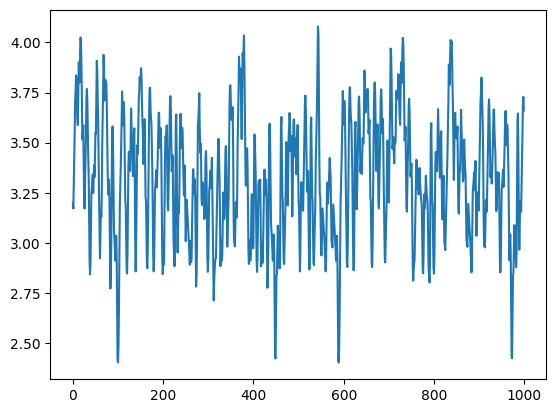

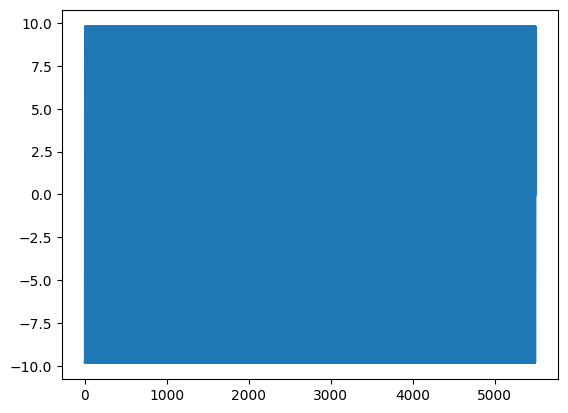

In [25]:
def main():
    g = 9.80665 #acceleration due to gravity
    m = 1    #mass of the bar
    l = 0.5      #length of the bar
    pi = 3.1415926535
    Gamma = 0.9 #Discount factor

    TauRange = 2*m*g*l  #max torque is twice of what is required to balances the mass in 90 degree configuration 

    res = 3  #resolution of the control input or the totan number of discretized values of the control inpput. This value should ne odd number

    ThetaRes = 101 #resolution of theta : creating the discrete state from the originally continuous state theta
                    #Odd number in the resolution will ensure that the theta for the vertically up position is included in the discrete state

    OmegaRes = 101

    OmegaRange = 14

    OmegaDisc = np.linspace(-OmegaRange, OmegaRange, OmegaRes)
    Ts = 0.05 #50 ms sample time

    k = 0.1 #damping constant

    ThetaTarget = pi #Angle at which we intend to stabilize

    ThetaDisc = np.linspace(0, 2*pi, ThetaRes)
    TauDisc = np.linspace(-TauRange, TauRange, res)

    InvPend = InvertedPendulum(m,l,g,k)

    Q_new = np.zeros((ThetaRes, OmegaRes, res))

    QOpt, ThetaHist = Q_learning(InvPend, Q_new, ThetaTarget, Ts, ThetaRes, OmegaRes, res, TauDisc, OmegaRange, ThetaDisc, OmegaDisc, Gamma,pi)

    # Controling pendulum using the learned Q-function
    Theta0 = 0
    Omega0 = 0
    simIter = 5500

    ThetaSim, TauSim = simulate(InvPend,QOpt, ThetaDisc,OmegaDisc, TauDisc, Theta0, Omega0, simIter, Ts, pi)

    plt.figure(1)
    plt.plot(ThetaSim[1000:2000])
    plt.figure(2)
    plt.plot(TauSim)
    
if __name__ == '__main__':
    main()